In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from src.dataloading import DataLoader
from src.preprocessing import Preprocesser
from src.modelling import VAE

2023-12-12 22:25:45,068 - tensorflow - WARNING - From C:\Users\Aless\anaconda3\envs\dslab\lib\site-packages\keras\src\losses.py:2976: The name tf.losses.sparse_softmax_cross_entropy is deprecated. Please use tf.compat.v1.losses.sparse_softmax_cross_entropy instead.



In [2]:
dataloader = DataLoader(path_to_data="../data/raw/P01")
df_list: list[pd.DataFrame] = dataloader.load_data()

2023-12-12 22:25:45,422 - src.dataloading - INFO - Found 10 .csv files in input path '../data/raw/P01' ...
2023-12-12 22:26:01,455 - src.dataloading - INFO - Parsed 10 .csv files into DataFrames ...


In [4]:
preprocesser = Preprocesser(df_list=df_list, condition="MathxHard", rolling_window_size=250, fixed_size=10990)
FEATURE_NAMES = list(preprocesser.df_list_processed[0].columns)
tensor: np.array = preprocesser.preprocess_data()
print(tensor.shape)

2023-12-12 22:26:01,485 - src.preprocessing - INFO - Starting preprocessing pipeline (Condition: MathxHard, Window Size: 250, Fixed Size: 10990) ...
2023-12-12 22:26:01,748 - src.preprocessing - INFO - Stacking data to 3D tensor ...
2023-12-12 22:26:01,750 - src.preprocessing - INFO - Finished preprocessing pipeline (Duration: 0.26s) ...


(10, 10990, 7)


In [5]:
vae = VAE(tensor=tensor, latent_dims=2)
vae.compile(optimizer="adam")
vae.build((None, tensor.shape[1], tensor.shape[2]))

2023-12-12 22:26:05,169 - tensorflow - WARNING - From C:\Users\Aless\anaconda3\envs\dslab\lib\site-packages\keras\src\backend.py:873: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

2023-12-12 22:26:05,973 - tensorflow - WARNING - From C:\Users\Aless\anaconda3\envs\dslab\lib\site-packages\keras\src\optimizers\__init__.py:309: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

2023-12-12 22:26:06,031 - tensorflow - WARNING - From C:\Users\Aless\anaconda3\envs\dslab\lib\site-packages\keras\src\engine\base_layer_utils.py:189: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.



In [6]:
history = vae.fit(tensor, epochs=16, batch_size=2)

Epoch 1/16
5/5 [==============================] - 59s 11s/step - loss: 5889.9491 - reconstruction_loss: 5732.6421 - kl_loss: 0.1895
Epoch 2/16
5/5 [==============================] - 54s 11s/step - loss: 5660.8423 - reconstruction_loss: 5533.1846 - kl_loss: 1.3575
Epoch 3/16
5/5 [==============================] - 56s 11s/step - loss: 5167.2463 - reconstruction_loss: 5248.9585 - kl_loss: 17.6864
Epoch 4/16
5/5 [==============================] - 53s 11s/step - loss: 4862.8564 - reconstruction_loss: 4911.9048 - kl_loss: 34.5394
Epoch 5/16
5/5 [==============================] - 52s 11s/step - loss: 4914.0777 - reconstruction_loss: 4515.7549 - kl_loss: 51.9017
Epoch 6/16
5/5 [==============================] - 53s 10s/step - loss: 4206.2874 - reconstruction_loss: 4072.8926 - kl_loss: 55.1977
Epoch 7/16
5/5 [==============================] - 54s 11s/step - loss: 3595.1641 - reconstruction_loss: 3629.3992 - kl_loss: 31.2198
Epoch 8/16
5/5 [==============================] - 60s 12s/step - loss: 

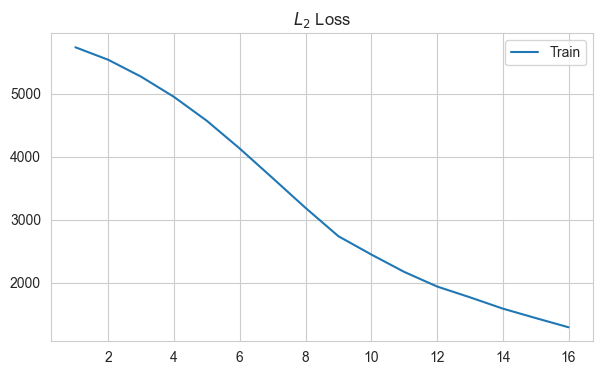

In [7]:
def plot_history(history):
    loss_dict = history.history

    loss_train = loss_dict["loss"]
    #loss_val = loss_dict["val_loss"]
    x = [i+1 for i in range(0, len(loss_train))]

    plt.figure(figsize=(7, 4))
    plt.title("$L_2$ Loss")
    sns.lineplot(x=x, y=loss_train, label="Train")
    #sns.lineplot(x=x, y=loss_val, label="Val")

plot_history(history)

In [8]:
val_sample = np.expand_dims(tensor[0], axis=0)
train_sample = np.expand_dims(tensor[0], axis=0)
print(val_sample.shape)
print(train_sample.shape)

(1, 10990, 7)
(1, 10990, 7)


In [9]:
val_sample_reconstructed = vae.predict(val_sample)
train_sample_reconstructed = vae.predict(train_sample)

1/1 [==============================] - 1s 885ms/step


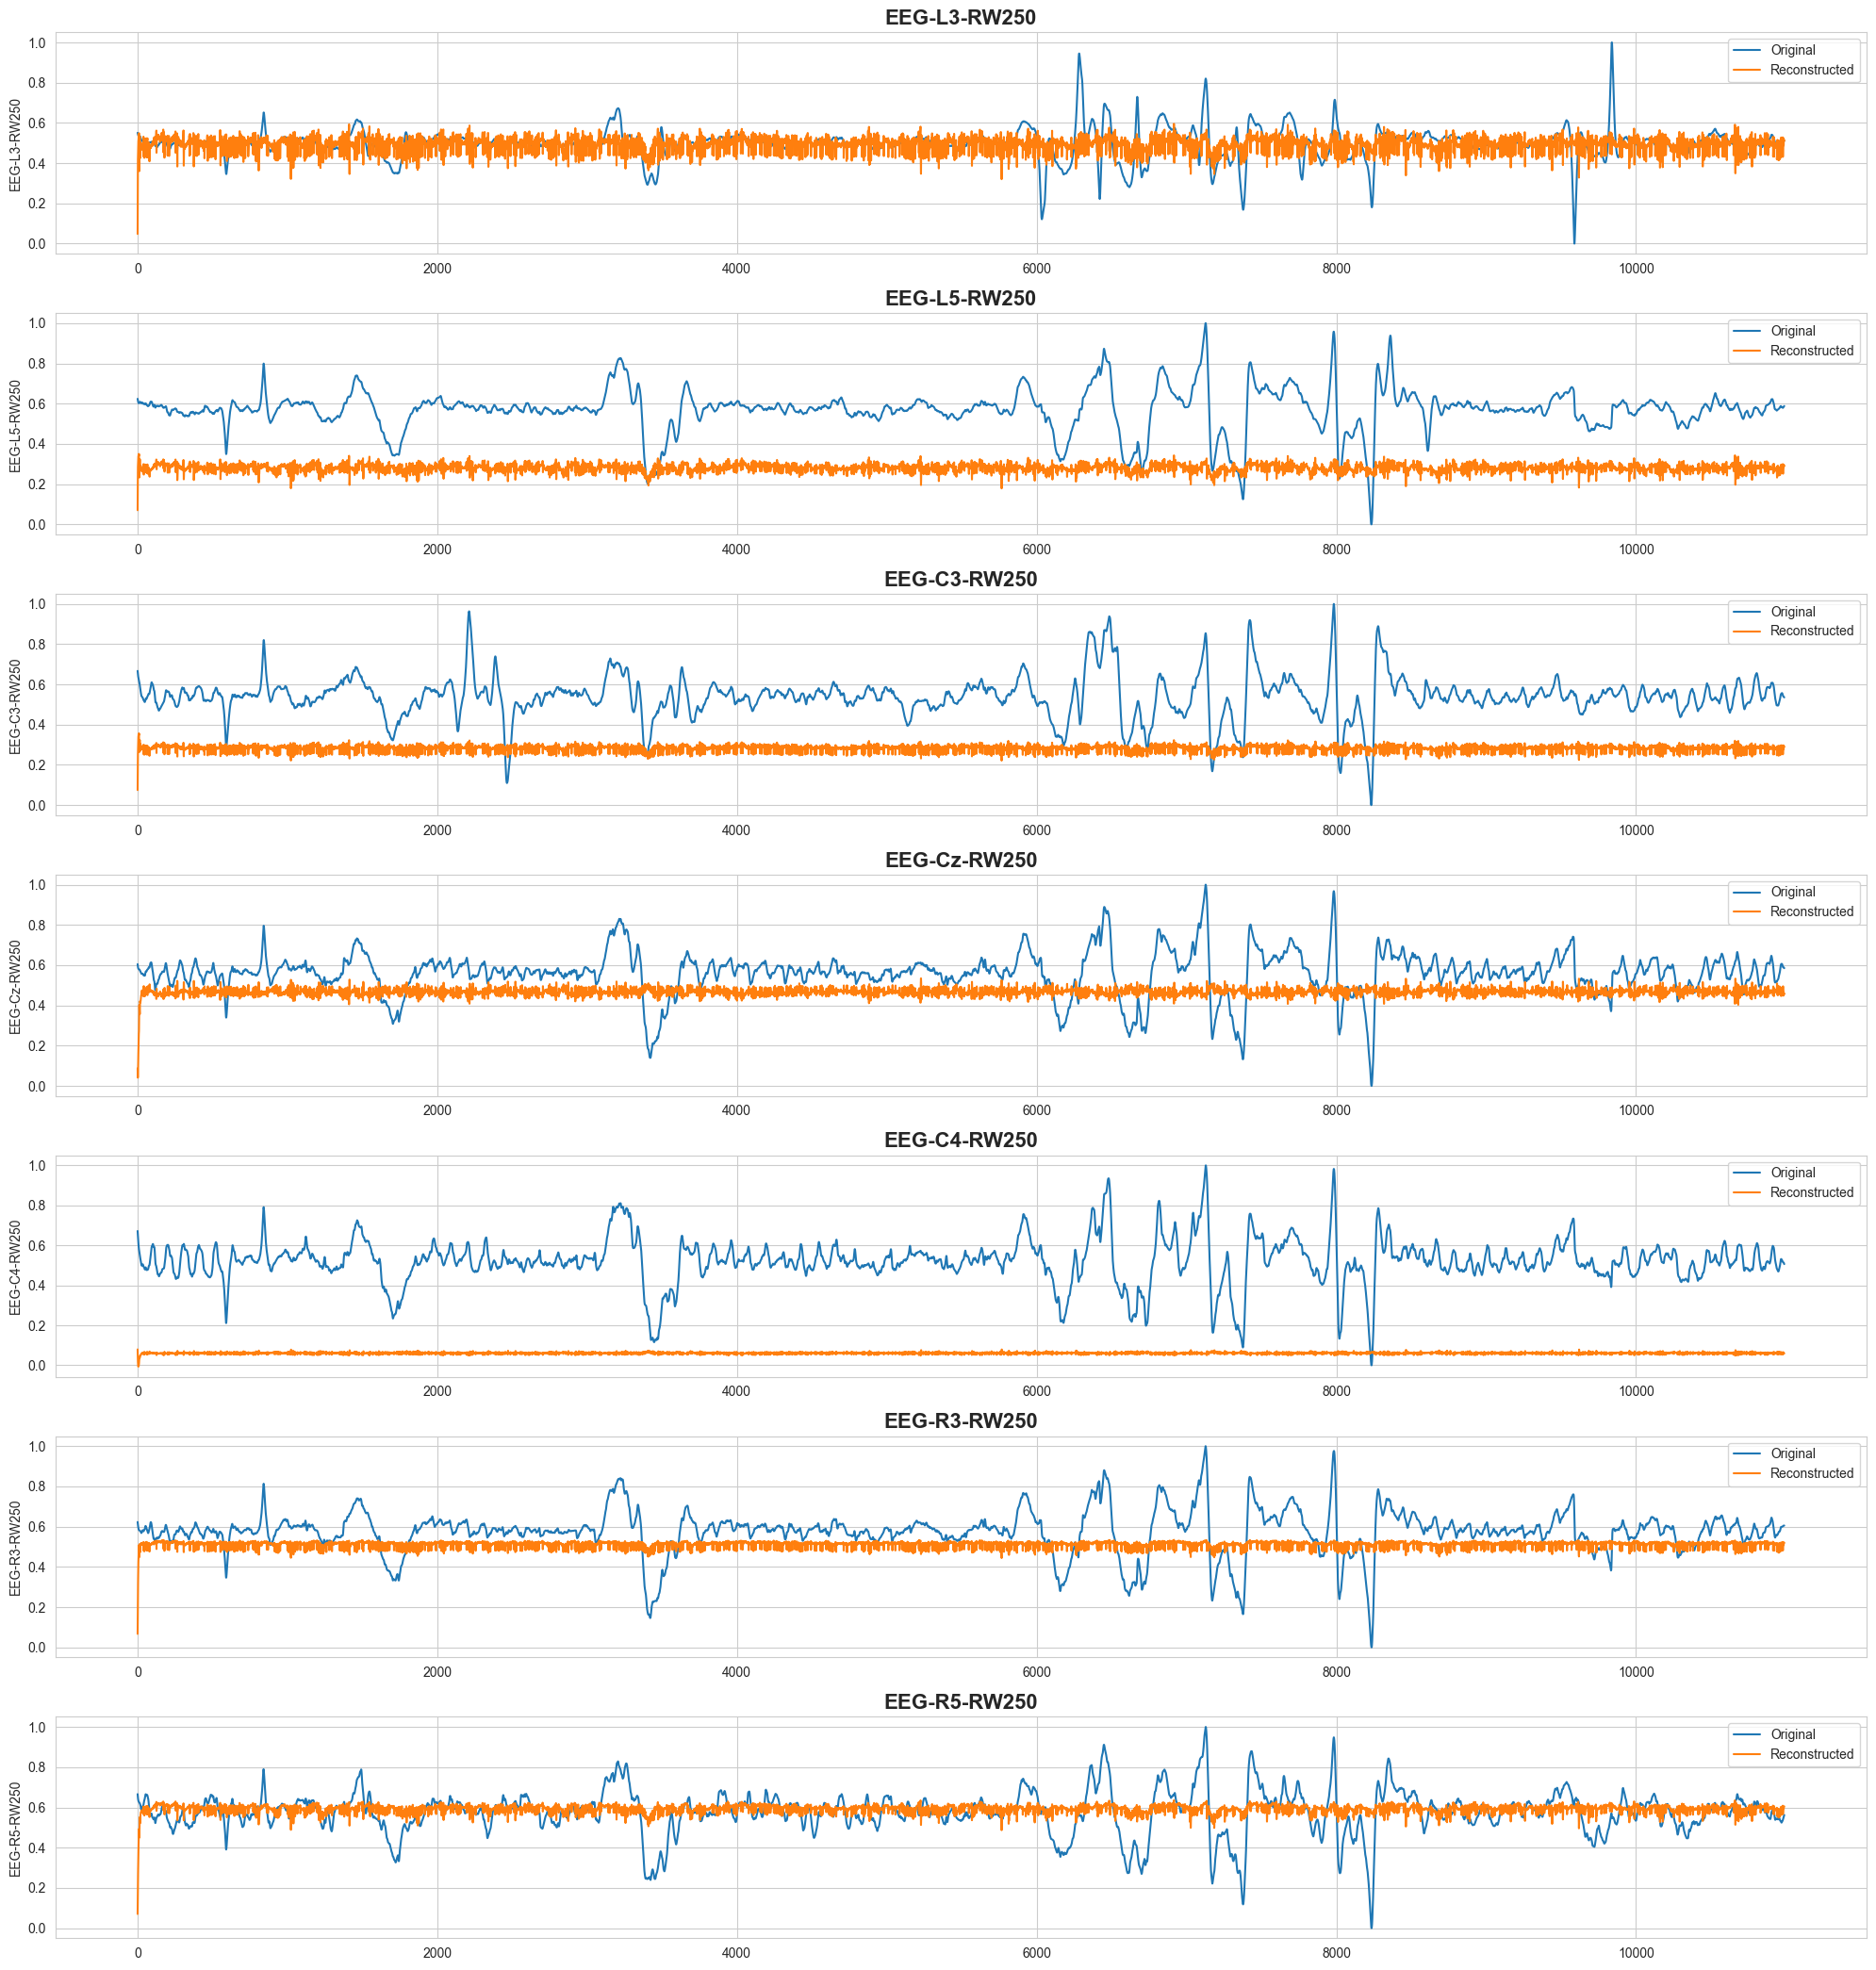

In [47]:
# Compare original and reconstruction
def compare_original_and_reconstruction(sample: np.array, sample_reconstructed: np.array) -> None:
    df_sample = pd.DataFrame(sample, columns=FEATURE_NAMES)
    df_reconstructed = pd.DataFrame(sample_reconstructed, columns=FEATURE_NAMES)

    fig, axes = plt.subplots(nrows=len(FEATURE_NAMES), ncols=1, figsize=(20, len(FEATURE_NAMES)*3))
    for col, ax in zip(FEATURE_NAMES, axes.flatten()):
        sns.lineplot(data=df_sample, x=df_sample.index, y=col, ax=ax, label="Original")
        sns.lineplot(data=df_reconstructed, x=df_reconstructed.index, y=col, ax=ax, label="Reconstructed")
        ax.set_title(col, fontweight="bold", size=16)
    fig.tight_layout()


compare_original_and_reconstruction(val_sample[0], val_sample_reconstructed[0])

In [51]:
# Generate synthetic data function using the decoder part of the VAE
def generate_time_series(num_samples, latent_dims):
    # Sample from the latent space
    latent_samples = np.random.normal(size=(num_samples, latent_dims))
    print(f"Latent Samples: {latent_samples}")
    # Generate synthetic data using the decoder model
    synthetic_data = vae.decoder(latent_samples).numpy()
    return synthetic_data

# Generate synthetic time series data
num_samples = 1
synthetic_time_series = generate_time_series(num_samples, 2)
print(synthetic_time_series.shape)

Latent Samples: [[-0.39577156 -1.88269319]]
(1, 10990, 7)


In [52]:
test = synthetic_time_series[0]
test.shape

(10990, 7)

In [53]:
test_df = pd.DataFrame(test, columns=FEATURE_NAMES)#, index=df_scaled_list[0].index)
test_df

,EEG-L3-RW250,EEG-L5-RW250,EEG-C3-RW250,EEG-Cz-RW250,EEG-C4-RW250,EEG-R3-RW250,EEG-R5-RW250
0,0.048128,0.070517,0.075017,0.086400,0.079416,0.067300,0.070540
1,0.062277,0.076011,0.081383,0.104164,0.078596,0.087600,0.095674
2,0.082836,0.084416,0.089739,0.120959,0.077136,0.109888,0.121166
3,0.087711,0.085521,0.093344,0.139652,0.077922,0.124454,0.137839
4,0.111930,0.094915,0.103113,0.155478,0.076347,0.147384,0.161627
...,...,...,...,...,...,...,...
10985,0.183027,0.106534,0.137438,0.360429,0.087417,0.276131,0.314848
10986,0.181886,0.105436,0.137121,0.361121,0.087863,0.276063,0.314481
10987,0.182871,0.105621,0.137312,0.361220,0.087963,0.276611,0.315096
10988,0.182794,0.105740,0.137094,0.360992,0.087943,0.276247,0.315057


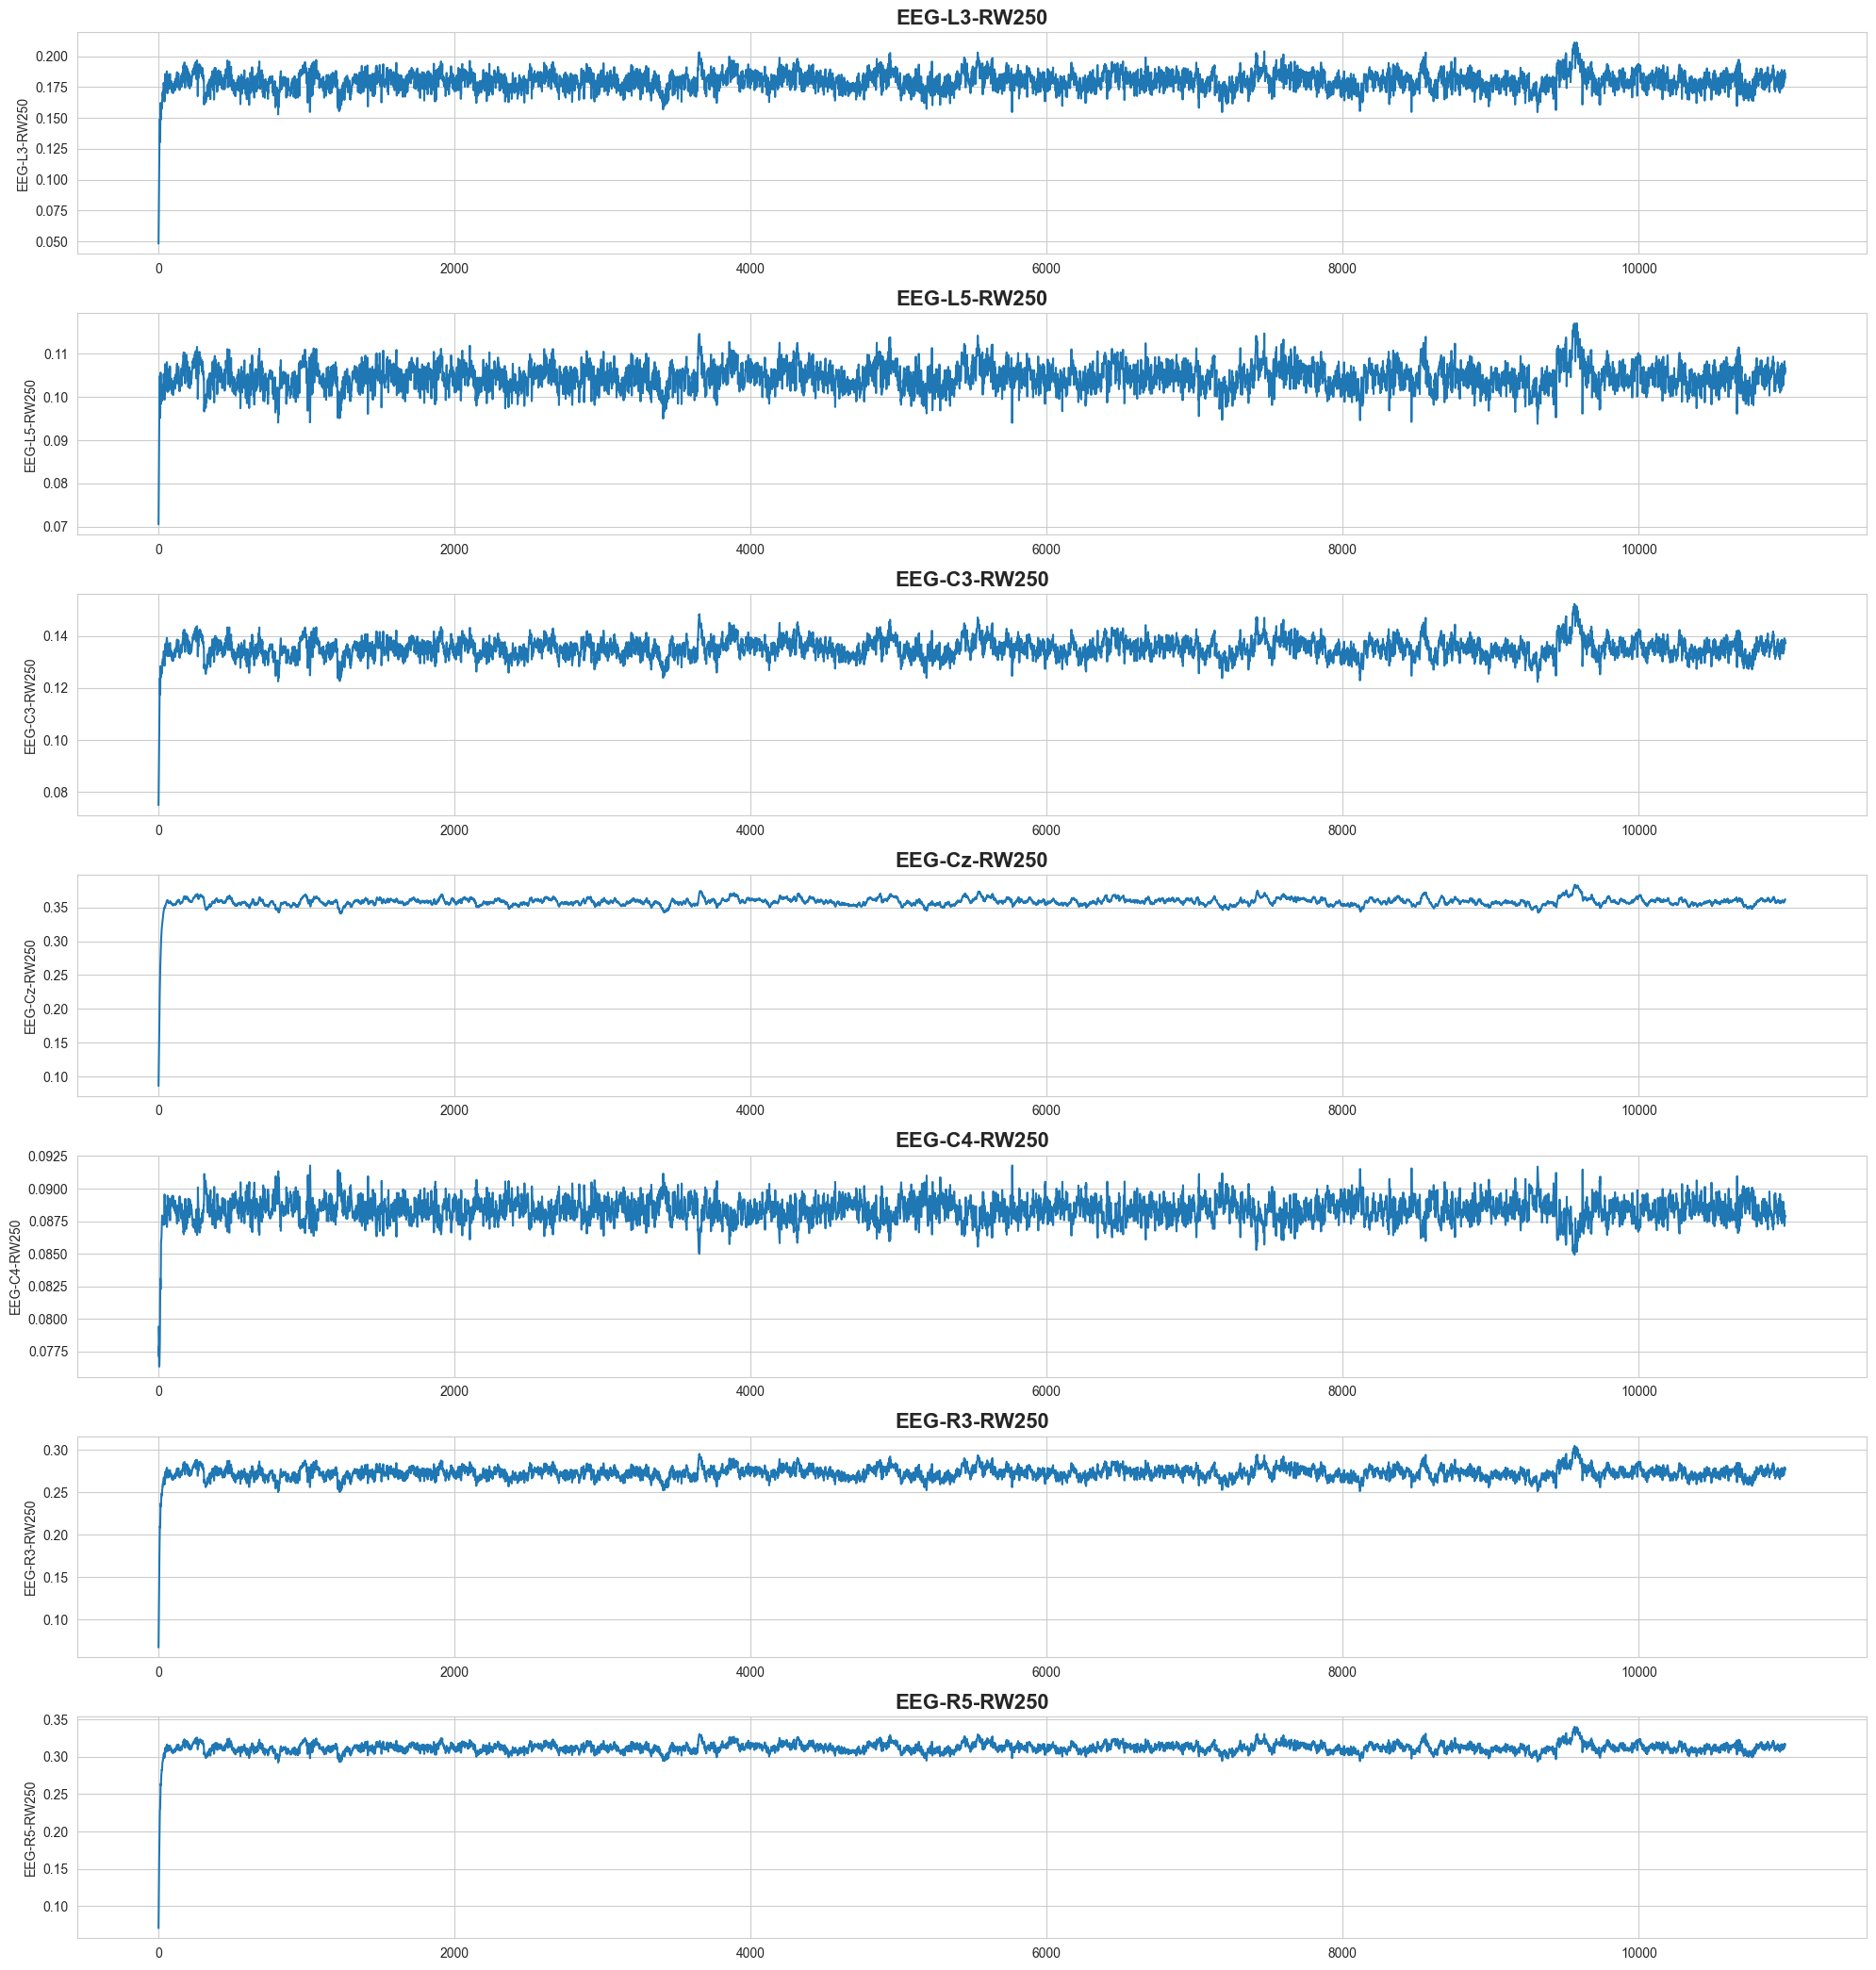

In [54]:
def plot_all_time_series(df: pd.DataFrame) -> None:
    """ Plots all Time Series (all float64 columns) in the provided DataFrame

    :param df: pd.DataFrame -- Input DataFrame
    :param time_col: str -- Name of the time column
    :return: None
    """
    cols = [x for x in list(df.columns) if x.endswith(f"RW{250}")]

    fig, axes = plt.subplots(nrows=len(cols), ncols=1, figsize=(20, len(cols)*3))
    for col, ax in zip(cols, axes.flatten()):
        sns.lineplot(data=df, x=df.index, y=col, ax=ax)
        ax.set_title(col, fontweight="bold", size=16)
    fig.tight_layout()

plot_all_time_series(test_df)